# Denver 2016 Bike Share Multi-Class Classification Modeling

## 1. Introduction

The data exploration performed on the Denver Trips dataset indicates weather variables have a significant impact on the number of checkouts. This section will focus on investigating the use of various classification models on the Trips data when combined with weather variables.

In [1]:
# Import necessary libraries and functions that are needed for the modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

In [2]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
dF = pd.read_csv("data/2016_Denver_Bike_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
dF.shape

(402962, 20)

In [5]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance,Checkout_WeekDay,Checkout_Month,Apparent_Temperature,Cloud_Cover,Humidity,Temperature,Visibility,Wind_Speed
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.26,4,1,9.71,0.0,0.53,14.99,10.0,3.2


In [6]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Date'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
#dF.drop(['Trip_Duration'], axis = 1, inplace = True)
#dF.drop(['Trip_Distance'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402962 entries, 0 to 402961
Data columns (total 11 columns):
Checkout_Hour           402962 non-null int64
Trip_Duration           402962 non-null int64
Trip_Distance           402962 non-null float64
Checkout_WeekDay        402962 non-null int64
Checkout_Month          402962 non-null int64
Apparent_Temperature    402962 non-null float64
Cloud_Cover             402962 non-null float64
Humidity                402962 non-null float64
Temperature             402962 non-null float64
Visibility              402962 non-null float64
Wind_Speed              402962 non-null float64
dtypes: float64(7), int64(4)
memory usage: 33.8 MB


In [8]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Month', 'Checkout_WeekDay', 'Cloud_Cover', 'Trip_Duration', 'Trip_Distance', 'Temperature', 
         'Apparent_Temperature', 'Wind_Speed', 'Humidity', 'Visibility', 'Checkout_Hour']]

In [9]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402962 entries, 0 to 402961
Data columns (total 11 columns):
Checkout_Month          402962 non-null int64
Checkout_WeekDay        402962 non-null int64
Cloud_Cover             402962 non-null float64
Trip_Duration           402962 non-null int64
Trip_Distance           402962 non-null float64
Temperature             402962 non-null float64
Apparent_Temperature    402962 non-null float64
Wind_Speed              402962 non-null float64
Humidity                402962 non-null float64
Visibility              402962 non-null float64
Checkout_Hour           402962 non-null int64
dtypes: float64(7), int64(4)
memory usage: 33.8 MB


In [10]:
dML = dF[~((dF.Checkout_Hour == 0)  | (dF.Checkout_Hour == 1)  | (dF.Checkout_Hour == 2)  | (dF.Checkout_Hour == 3)  |
         (dF.Checkout_Hour == 4) | (dF.Checkout_Hour == 5))]

In [11]:
dML.shape

(400407, 11)

In [12]:
#Define a generic function using Pandas replace function
def coding(col, codeDict):
  colCoded = pd.Series(col, copy=True)
  for key, value in codeDict.items():
    colCoded.replace(key, value, inplace=True)
  return colCoded

data = dF.copy(deep=True)
print('Before Coding:')
print(pd.value_counts(data["Checkout_Hour"]).tolist())
data["Class_Label"] = coding(data["Checkout_Hour"], {5: 1,
                                                     6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7,
                                                     12: 8, 13: 9, 14: 10, 15: 11, 16: 12, 17: 13,
                                                     18: 14, 19: 15, 20: 16, 21: 17, 22: 18, 23: 19})
print('\nAfter Coding:')
print(pd.value_counts(data["Class_Label"]))

Before Coding:
[39014, 36012, 31619, 30256, 28331, 28270, 28113, 25879, 24866, 24623, 20248, 19762, 16828, 13359, 11338, 9885, 7941, 4063, 2522, 33]

After Coding:
13    39014
12    36012
4     31652
11    30256
9     28331
10    28270
8     28113
14    25879
7     24866
3     24623
5     20248
6     19762
15    16828
16    13359
17    11338
2      9885
18     7941
19     4063
1      2522
Name: Class_Label, dtype: int64


In [13]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Cloud_Cover', 'Trip_Duration', 'Trip_Distance', 'Temperature', 
           'Apparent_Temperature', 'Wind_Speed', 'Humidity', 'Visibility', 'Class_Label', 'Checkout_Hour']]

In [14]:
array = data.values

In [15]:
X = array[:,0:10]

In [16]:
y = array[:,10]

## Feature Correlations

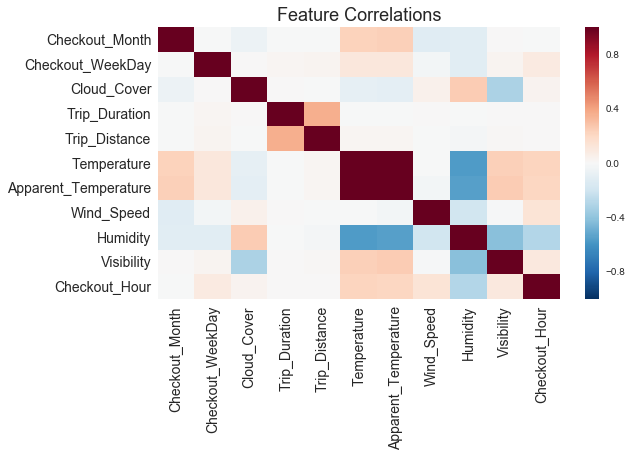

In [17]:
feature_corr = data.drop(['Class_Label'], axis = 1)
plt.figure(figsize=(9,5))
ax = sns.heatmap(feature_corr.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [18]:
features = ["Checkout_Month", "Checkout_WeekDay", 'Trip_Duration', 'Trip_Distance',  
            'Cloud_Cover', 'Temperature', 'Apparent_Temperature', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Class_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

## 2. Modeling - All Features

In [19]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.figure(figsize=(10,5))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features, fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel("Feature importance", fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.ylim(-1, n_features)

In [20]:
def get_class_metrics(model, actual, predicted):
    class_metrics = {'Accuracy' : metrics.accuracy_score(actual, predicted),
                         'F1 (macro)' : metrics.f1_score(actual, predicted, average='macro'),
                         'F1 (micro)' : metrics.f1_score(actual, predicted, average='micro'),
                         'Precision (macro)' : metrics.precision_score(actual, predicted,  average='macro'),
                         'Precision (micro)' : metrics.precision_score(actual, predicted,  average='micro'),
                         'Recall (macro)' : metrics.recall_score(actual, predicted,  average='macro'),
                         'Recall (micro)' : metrics.recall_score(actual, predicted,  average='micro')}
    dML_metrics = pd.DataFrame.from_dict(class_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

In [21]:
def perform_classification(model, clfr, features):   
 
    clfr.fit(X_train, y_train)
    ypred = clfr.predict(X_test)
    got_metrics = get_class_metrics(model, y_test, ypred)
    print(model,'\n')
    print("Accuracy on training set: {:.3f}".format(clfr.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(clfr.score(X_test, y_test)))
    print('\nConfusion Matrix:')
    print(metrics.confusion_matrix(y_test, ypred))
    print('\nClassification Report:')
    print(metrics.classification_report(y_test, ypred))
    return got_metrics, ypred

In [22]:
def perform_cross_validation(clfr):
    shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
    scores = cross_val_score(clfr, X, y, cv=shuffle_split)
    print("Cross-validation scores:\n{}".format(scores))

#### Decision Tree Classification

Decision Tree Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.999

Confusion Matrix:
[[ 1002    21    12     0     0     4     0     0     0     0     1     3
      1     0     2     0     2     2     4]
 [    8  3908     4     1     1     0     0     2     0     0     0     0
      1     0     0     0     2     0     2]
 [    1     1  9706     2     0     2     0     0     1     1     0     0
      0     3     0     0     3     0     4]
 [    1     2     4 12705     2     0     0     0     0     0     0     0
      3     2     0     2     1     0     1]
 [    0     0     3     3  8036     0     0     0     0     0     0     0
      0     0     0     0     0     1     1]
 [    0     0     0     0     0  7948     0     0     0     0     0     0
      0     0     0     0     1     4     0]
 [    0     0     0     0     0     0  9981     0     0     0     0     0
      0     0     0     0     0     0     1]
 [    0     0     0     0     0     0     1 11185     0  

,Decision Tree Classification
Accuracy,0.998865
F1 (macro),0.996534
F1 (micro),0.998865
Precision (macro),0.997204
Precision (micro),0.998865
Recall (macro),0.995891
Recall (micro),0.998865


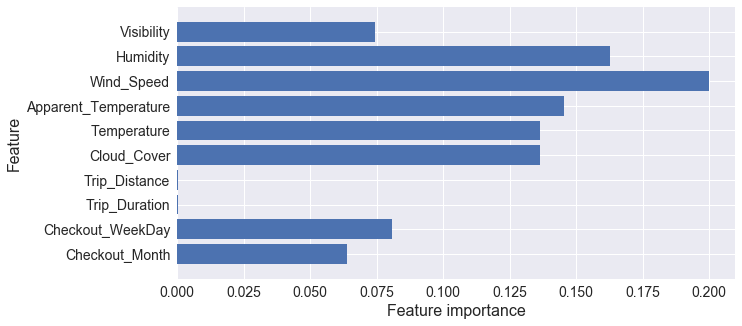

In [23]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)
dtc, y_pred = perform_classification('Decision Tree Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf)
dtc.sort_index()

#### Linear (Logistic) Classification

In [24]:
# logistic regression
from sklearn import linear_model
clf = linear_model.LogisticRegression(random_state=0)
lin_reg, y_pred = perform_classification('Logistic Classification', clf, features)
perform_cross_validation(clf)
lin_reg.sort_index()

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Classification 

Accuracy on training set: 0.173
Accuracy on test set: 0.171

Confusion Matrix:
[[   0    0  481  469    1   10    1    0    0    1    2   29   51    9
     0    0    0    0    0]
 [   0    0 1362 1957  147   21    2    6    1    1    3  107  282   29
     0    0   11    0    0]
 [   0    0 3595 4804   81   45   33   30    0    1   37  223  798   77
     0    0    0    0    0]
 [   0    0 2263 7120   57  136  119  180   30    9   73  419 2200   80
     0   32    4    1    0]
 [   0    0  528 2988  368  140  406  296   53   23  270  541 2212  146
     0   14   59    0    0]
 [   0    0  281 2189   50  227  425  767  154   11  534 1098 2063   80
     1   43   30    0    0]
 [   0    0   89 1805   58  219  389 1007  345   89 1312 1426 3032  180
     0    0   31    0    0]
 [   0    0   33 1089   66   22  348 1259  416  192 2232 1228 3936  348
     0    0   18    0    0]
 [   0    0   35 1146   49   26   84  706  661  201 2526 2273 3642   38
     0    0    0    0  

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross-validation scores:
[ 0.17028901  0.16394598  0.17113276  0.16932118  0.16890426  0.17202615
  0.16935096  0.16755426  0.17126677  0.17220979]


,Logistic Classification
Accuracy,0.171393
F1 (macro),0.091614
F1 (micro),0.171393
Precision (macro),0.128753
Precision (micro),0.171393
Recall (macro),0.117052
Recall (micro),0.171393


#### Random Forest Classification

Random Forest Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.999

Confusion Matrix:
[[ 1016    16     6     5     0     1     0     1     0     0     1     0
      0     1     4     0     0     3     0]
 [    7  3908     4     0     1     0     0     0     2     0     0     0
      0     0     2     0     1     0     4]
 [    4     4  9712     3     1     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    6     3     4 12704     1     2     0     0     0     0     0     0
      0     1     0     0     0     1     1]
 [    0     1     0     3  8040     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     4  7949     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0  9982     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0 11186     1  

,Random Forest Classification
Accuracy,0.999125
F1 (macro),0.997270
F1 (micro),0.999125
Precision (macro),0.997803
Precision (micro),0.999125
Recall (macro),0.996747
Recall (micro),0.999125


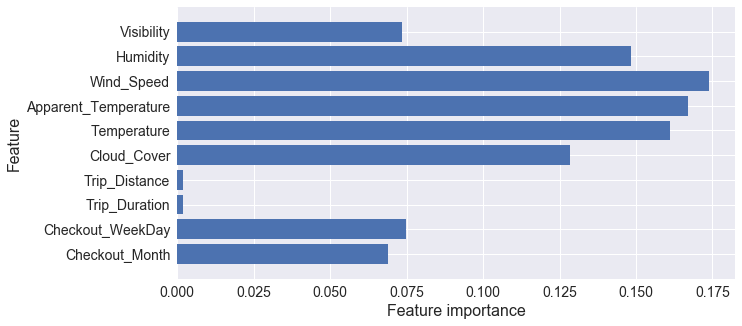

In [25]:
# Random Forest Classifier
clf = RandomForestClassifier(random_state=0)
rfc, y_pred = perform_classification('Random Forest Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf)
rfc.sort_index()

#### Extra Trees Classification

Extra Trees Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.999

Confusion Matrix:
[[ 1024    17     6     2     1     1     0     0     0     0     1     0
      1     0     0     0     0     1     0]
 [    0  3917     8     1     0     1     0     2     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     5  9713     5     0     0     0     0     0     0     0     0
      1     0     0     0     0     0     0]
 [    6     1     8 12705     0     0     0     1     0     0     0     1
      0     1     0     0     0     0     0]
 [    0     0     0     3  8040     0     0     0     0     0     0     0
      0     0     0     0     1     0     0]
 [    0     0     0     0     0  7949     0     0     0     0     0     0
      0     0     0     0     0     4     0]
 [    0     0     0     0     0     0  9982     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1 11186     0    

,Extra Trees Classification
Accuracy,0.999287
F1 (macro),0.998073
F1 (micro),0.999287
Precision (macro),0.998689
Precision (micro),0.999287
Recall (macro),0.997472
Recall (micro),0.999287


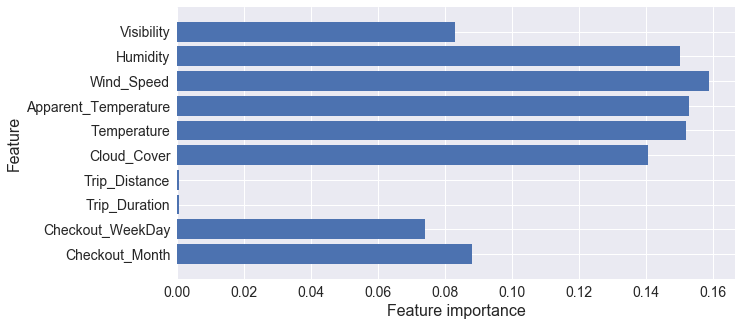

In [26]:
# Extra Trees Classifier
clf = ExtraTreesClassifier(random_state=0)
etc, y_pred = perform_classification('Extra Trees Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf)
etc.sort_index()

#### Naive Bayes Classification

In [27]:
# Naive Bayes Classifier
clf = naive_bayes.GaussianNB()
nbg, y_pred = perform_classification('Naive Bayes Classification', clf, features)
perform_cross_validation(clf)
nbg.sort_index()

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Naive Bayes Classification 

Accuracy on training set: 0.135
Accuracy on test set: 0.134

Confusion Matrix:
[[   0   34  808   13    7    0    1    0    0    0    1   62   21    0
     0  103    0    0    4]
 [   0  292 2820   85   36    0    3    0    0    0    4  131  122    0
     0  413   21    1    1]
 [   0  174 6854  294   61    3    1    0    0    0    7  282  246    1
     8 1643  120    1   29]
 [   0  279 7057  454   53    6   11    2   17   12   23 1409  998    6
     0 2231  136    1   28]
 [   0  470 2472  182   99   11   16   28   28   37   41 1691 1024   32
     0 1714  199    0    0]
 [   0  124 1786  126   91   17   24   67  119   75   67 3072 1021    8
    15 1235  106    0    0]
 [   0  175 1444  140   88   10   15   73  191  183  110 5136 1125    7
    51 1173   61    0    0]
 [   0  251 1105   96   72    7   10  272  156  356  139 6628 1039   46
     0  638  372    0    0]
 [   0  100 1076  113   46    1   10  141  172  366  128 7428 1155   10
     3  508  130    

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1054
          2       0.09      0.07      0.08      3929
          3       0.18      0.70      0.28      9724
          4       0.20      0.04      0.06     12723
          5       0.10      0.01      0.02      8044
          6       0.20      0.00      0.00      7953
          7       0.11      0.00      0.00      9982
          8       0.12      0.02      0.04     11187
          9       0.13      0.02      0.03     11387
         10       0.12      0.03      0.04     11380
         11       0.10      0.01      0.02     12001
         12       0.13      0.66      0.22     14460
         13       0.12      0.12      0.12     15505
         14       0.16      0.00      0.01     10446
         15       0.00      0.00      0.00      6720
         16       0.08      0.25      0.12      5295
         17       0.08      0.05      0.06      4616
         18       0.11      0.00      0.00   

,Naive Bayes Classification
Accuracy,0.133939
F1 (macro),0.058921
F1 (micro),0.133939
Precision (macro),0.110323
Precision (micro),0.133939
Recall (macro),0.104769
Recall (micro),0.133939


#### Nearest Neighbors Classification

In [28]:
# Nearest Neighbors Classifier
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn, y_pred = perform_classification('Nearest Neighbors Classification', clf, features)
perform_cross_validation(clf)
knn.sort_index()

Nearest Neighbors Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.822

Confusion Matrix:
[[  494   189   101    59    30    11    18    11     6     8     3     6
     18    13    17    11    17    25    17]
 [   70  3066   249   129    69    37    18    20    11    12    12    13
     27    48    13    26    37    31    41]
 [   29   204  8707   181   101    57    41    22    23    17    27    36
     37    49    38    42    50    30    33]
 [   13    88   160 11494   162    88    72    57    48    35    28    41
     47    68    56    65    83    76    42]
 [    9    38   129   205  6493   145    89    59    90    67    60    75
    132    67    90   106    80    57    53]
 [    9    38    72    95   173  6211   216   136    83   107    86   113
    103   114   122    82   114    53    26]
 [    3    24    51   102   106   159  8196   218   123   120   135   153
    178   106    94   103    60    28    23]
 [    5    19    39    71    56   122   204  9377   2

,Nearest Neighbors Classification
Accuracy,0.822490
F1 (macro),0.784425
F1 (micro),0.822490
Precision (macro),0.796228
Precision (micro),0.822490
Recall (macro),0.775852
Recall (micro),0.822490


## Classification Summary - All Features

In [29]:
# Classifcation Summary
print("Classification Summary before Feature Selection\n")
class_metrics = pd.concat([dtc, lin_reg, rfc, etc, nbg, knn] , axis=1)
class_metrics.sort_index()

Classification Summary before Feature Selection



,Decision Tree Classification,Logistic Classification,Random Forest Classification,Extra Trees Classification,Naive Bayes Classification,Nearest Neighbors Classification
Accuracy,0.998865,0.171393,0.999125,0.999287,0.133939,0.822490
F1 (macro),0.996534,0.091614,0.997270,0.998073,0.058921,0.784425
F1 (micro),0.998865,0.171393,0.999125,0.999287,0.133939,0.822490
Precision (macro),0.997204,0.128753,0.997803,0.998689,0.110323,0.796228
Precision (micro),0.998865,0.171393,0.999125,0.999287,0.133939,0.822490
Recall (macro),0.995891,0.117052,0.996747,0.997472,0.104769,0.775852
Recall (micro),0.998865,0.171393,0.999125,0.999287,0.133939,0.822490


## 3. Modeling - Selected Features

In [30]:
dF.drop(['Trip_Duration'], axis = 1, inplace = True)
dF.drop(['Trip_Distance'], axis = 1, inplace = True)

In [31]:
#Define a generic function using Pandas replace function
def coding(col, codeDict):
  colCoded = pd.Series(col, copy=True)
  for key, value in codeDict.items():
    colCoded.replace(key, value, inplace=True)
  return colCoded
data = dF.copy(deep=True)
data["Class_Label"] = coding(data["Checkout_Hour"], {5: 1,
                                                     6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7,
                                                     12: 8, 13: 9, 14: 10, 15: 11, 16: 12, 17: 13,
                                                     18: 14, 19: 15, 20: 16, 21: 17, 22: 18, 23: 19})

In [32]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Cloud_Cover', 'Temperature', 
           'Apparent_Temperature', 'Wind_Speed', 'Humidity', 'Visibility', 'Class_Label', 'Checkout_Hour']]

In [33]:
array = data.values
X = array[:,0:8]
y = array[:,8]

In [34]:
features = ["Checkout_Month", "Checkout_WeekDay",   
            'Cloud_Cover', 'Temperature', 'Apparent_Temperature', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Class_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#### Decision Tree Classification

Decision Tree Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.999

Confusion Matrix:
[[ 1025     2    10     0     2     4     0     0     0     1     2     3
      0     0     1     0     2     2     0]
 [    2  3915     6     1     1     1     0     0     0     0     0     0
      1     0     0     0     1     0     1]
 [    0     1  9713     3     0     2     0     0     1     0     0     0
      0     4     0     0     0     0     0]
 [    3     1     3 12708     2     0     0     0     0     0     0     0
      5     0     0     0     0     0     1]
 [    0     0     3     1  8040     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0  7949     0     0     0     0     0     0
      0     0     0     0     0     4     0]
 [    0     0     0     0     0     0  9982     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0 11186     0  

,Decision Tree Classification
Accuracy,0.999330
F1 (macro),0.998256
F1 (micro),0.999330
Precision (macro),0.998903
Precision (micro),0.999330
Recall (macro),0.997624
Recall (micro),0.999330


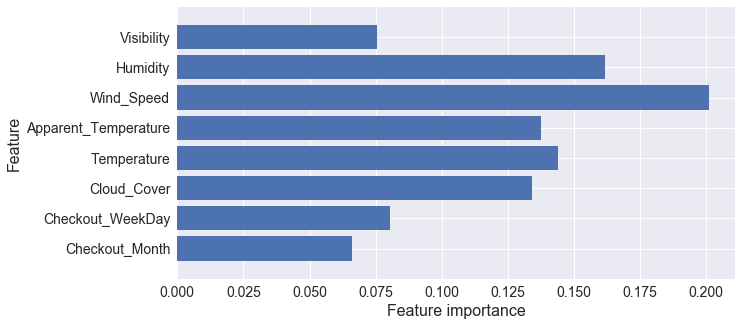

In [35]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)
dtc, y_pred = perform_classification('Decision Tree Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf)
dtc.sort_index()

#### Linear (Logistic Regression) Classification

In [36]:
# logistic regression
from sklearn import linear_model
clf = linear_model.LogisticRegression(random_state=0)
lin_reg, y_pred = perform_classification('Logistic Classification', clf, features)
perform_cross_validation(clf)
lin_reg.sort_index()

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Classification 

Accuracy on training set: 0.171
Accuracy on test set: 0.170

Confusion Matrix:
[[   0    0  479  474    0    9    0    0    0    0    3   34   46    9
     0    0    0    0    0]
 [   0    0 1356 1974  141   19    0    6    1    0    3  104  285   29
     0    0   11    0    0]
 [   0    0 3622 4788   76   38   33   29    0    1   37  214  809   77
     0    0    0    0    0]
 [   0    0 2310 7056   87  106  131  232   35    0   73  401 2217   41
     0   33    0    1    0]
 [   0    0  561 2944  356  218  350  291   77    0  282  550 2195  147
     0   13   60    0    0]
 [   0    0  239 2280   43  223  410  798  127   41  488 1156 2001   77
     0   40   30    0    0]
 [   0    0  114 1794   55  232  360  990  297   84 1320 1452 3070  183
     0    0   31    0    0]
 [   0    0   37 1056   67   15  354 1204  410  182 2306 1193 3976  387
     0    0    0    0    0]
 [   0    0   36 1167   42    9   82  667  669   92 2766 2163 3655   39
     0    0    0    0  

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross-validation scores:
[ 0.17051732  0.17358957  0.16767338  0.17150501  0.16949489  0.16920206
  0.17019471  0.17106328  0.17193184  0.17186732]


,Logistic Classification
Accuracy,0.170276
F1 (macro),0.090561
F1 (micro),0.170276
Precision (macro),0.121817
Precision (micro),0.170276
Recall (macro),0.116308
Recall (micro),0.170276


#### Random Forest Classification

Random Forest Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.999

Confusion Matrix:
[[ 1024    19     2     1     1     1     1     1     0     0     0     0
      0     0     0     1     0     2     1]
 [    2  3916     6     0     0     0     0     2     0     0     0     0
      0     0     0     0     0     0     3]
 [    0     8  9712     3     1     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    8     2     2 12706     0     0     2     0     0     0     0     0
      0     1     0     0     0     0     2]
 [    0     0     0     0  8040     0     0     0     0     0     0     0
      0     0     0     3     1     0     0]
 [    0     0     0     0     4  7949     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0  9982     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0 11186     1  

,Random Forest Classification
Accuracy,0.999293
F1 (macro),0.997880
F1 (micro),0.999293
Precision (macro),0.998247
Precision (micro),0.999293
Recall (macro),0.997522
Recall (micro),0.999293


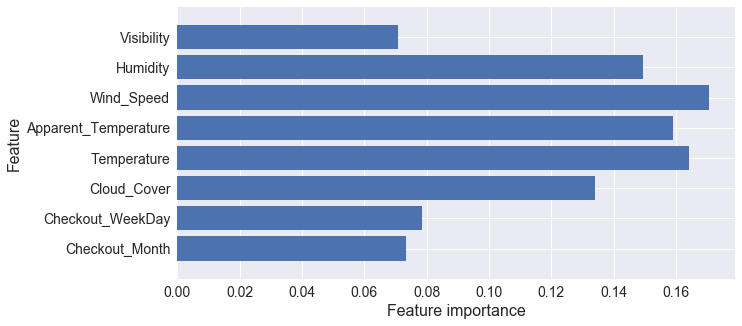

In [37]:
# Random Forest Classifier
clf = RandomForestClassifier(random_state=0)
rfc, y_pred = perform_classification('Random Forest Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf)
rfc.sort_index()

#### Extra Trees Classification

Extra Trees Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.999

Confusion Matrix:
[[ 1022    14     5     5     1     1     2     0     0     0     0     0
      1     0     0     0     0     1     2]
 [    2  3915     5     0     0     0     0     0     0     0     0     2
      0     0     0     0     1     0     4]
 [    0     8  9713     3     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    8     0     4 12705     0     0     0     0     0     1     0     0
      0     2     0     0     3     0     0]
 [    1     0     0     0  8040     3     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     4  7949     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0  9982     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1 11186     0    

,Extra Trees Classification
Accuracy,0.999280
F1 (macro),0.997823
F1 (micro),0.999280
Precision (macro),0.998240
Precision (micro),0.999280
Recall (macro),0.997415
Recall (micro),0.999280


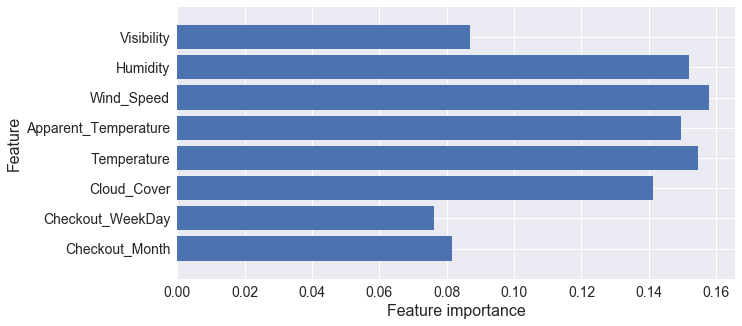

In [38]:
# Extra Trees Classifier
clf = ExtraTreesClassifier(random_state=0)
etc, y_pred = perform_classification('Extra Trees Classification', clf, features)
perform_cross_validation(clf)
plot_feature_importances(clf)
etc.sort_index()

#### Naive Bayes Classification

In [39]:
# Naive Bayes Classifier
clf = naive_bayes.GaussianNB()
nbg, y_pred = perform_classification('Naive Bayes Classification', clf, features)
perform_cross_validation(clf)
nbg.sort_index()

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Naive Bayes Classification 

Accuracy on training set: 0.150
Accuracy on test set: 0.148

Confusion Matrix:
[[   0   13  607  200    5    0    0    0    0    0    0    9   79    0
     0  131    0   10    0]
 [   0  230 2052  666   38    1    0    0    1    1    0   57  213    0
     0  628   35    7    0]
 [   0  121 5143 1545   16    6    0    0    5    7    0  108  530    0
    35 2040  142   26    0]
 [   0  236 4529 2734    3  108   35   74  190  233    0  206 1740   55
     0 2424  142   14    0]
 [   0  323 1345 1088  269   47  137   24   64  841    0  266 1648   82
     0 1781  129    0    0]
 [   0  100  826  972  101   45  336   43  430 1459    0  572 1710   34
     0 1238   87    0    0]
 [   0  136  631  849  100  135  311  178  680 2640   52  853 2318   59
     0 1006   34    0    0]
 [   0  167  351  846  233   80  138  328  255 4062  294  965 2481  182
     0  650  155    0    0]
 [   0   54  435  648   50  111  148  210  694 4145  222 1527 2438  108
     0  526   71    

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1054
          2       0.10      0.06      0.07      3929
          3       0.23      0.53      0.32      9724
          4       0.17      0.21      0.19     12723
          5       0.15      0.03      0.05      8044
          6       0.05      0.01      0.01      7953
          7       0.18      0.03      0.05      9982
          8       0.11      0.03      0.05     11187
          9       0.14      0.06      0.08     11387
         10       0.13      0.41      0.20     11380
         11       0.22      0.06      0.09     12001
         12       0.19      0.20      0.19     14460
         13       0.14      0.28      0.18     15505
         14       0.17      0.02      0.04     10446
         15       0.00      0.00      0.00      6720
         16       0.07      0.23      0.11      5295
         17       0.08      0.03      0.04      4616
         18       0.12      0.01      0.01   

,Naive Bayes Classification
Accuracy,0.148475
F1 (macro),0.088862
F1 (micro),0.148475
Precision (macro),0.117142
Precision (micro),0.148475
Recall (macro),0.115514
Recall (micro),0.148475


#### Nearest Neighbors Classification

In [40]:
# Nearest Neighbors Classifier
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn, y_pred = perform_classification('Nearest Neighbors Classification', clf, features)
perform_cross_validation(clf)
knn.sort_index()

Nearest Neighbors Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.999

Confusion Matrix:
[[ 1022     9     3     2     1     4     4     0     1     0     0     0
      5     0     0     2     0     1     0]
 [    3  3915     5     0     0     0     0     0     0     1     1     0
      0     0     1     1     0     0     2]
 [    0     5  9713     4     2     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    4     0     6 12706     1     0     2     0     0     0     0     2
      0     0     0     1     0     1     0]
 [    0     0     0     0  8040     0     0     0     0     0     0     0
      0     0     0     4     0     0     0]
 [    0     0     0     0     0  7949     0     0     0     0     0     0
      0     0     0     0     0     0     4]
 [    0     0     0     0     0     0  9982     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0 11186    

,Nearest Neighbors Classification
Accuracy,0.999287
F1 (macro),0.997960
F1 (micro),0.999287
Precision (macro),0.998502
Precision (micro),0.999287
Recall (macro),0.997431
Recall (micro),0.999287


## Classification - Selected Features

In [41]:
# Classifcation Summary
print("Classification Summary after Feature Selection\n")
class_metrics = pd.concat([dtc, lin_reg, rfc, etc, nbg, knn] , axis=1)
class_metrics.sort_index()

Classification Summary after Feature Selection



,Decision Tree Classification,Logistic Classification,Random Forest Classification,Extra Trees Classification,Naive Bayes Classification,Nearest Neighbors Classification
Accuracy,0.999330,0.170276,0.999293,0.999280,0.148475,0.999287
F1 (macro),0.998256,0.090561,0.997880,0.997823,0.088862,0.997960
F1 (micro),0.999330,0.170276,0.999293,0.999280,0.148475,0.999287
Precision (macro),0.998903,0.121817,0.998247,0.998240,0.117142,0.998502
Precision (micro),0.999330,0.170276,0.999293,0.999280,0.148475,0.999287
Recall (macro),0.997624,0.116308,0.997522,0.997415,0.115514,0.997431
Recall (micro),0.999330,0.170276,0.999293,0.999280,0.148475,0.999287


## 4. Summary

The Decision Tree, Random Forest, Extra Trees and Nearest Neighbors models fit the data extremely well. The Logistic and Naive Bayes models don't fit well at all.